# **CNN** *Pytorch*

### **Imports...**

In [2]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

### **GPU/MPS/CPU...**

In [3]:
if torch.cuda.is_available(): 
    device = "cuda"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"
print(
    f"~~~~~~~~~~~~~~~~~ \n"
    f"Using device: {device} \n"
    f"~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~ 
Using device: mps 
~~~~~~~~~~~~~~~~~


### **CNN...**

In [4]:

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=26): 
       
        super(CNN, self).__init__()

        #1ST CONVOLUTIONAL LAYER
        self.conv1 = nn.Conv2d( 
            in_channels=in_channels,  
            out_channels=64, 
            kernel_size=3, 
            stride=1,  
            padding=1) 
        self.bn1 = nn.BatchNorm2d(64)
        
        #2ND CONVOLUTIONAL LAYER
        self.conv2 = nn.Conv2d(  
            in_channels=64,  
            out_channels=128, 
            kernel_size=3, 
            stride=1, 
            padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #3RD CONVOLUTIONAL LAYER
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        
        #POOLING LAYER
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #DROPOUT LAYER (FOR REGULARIZATION)
        self.drop_conv = nn.Dropout2d(p=0.2)
        self.drop_fc = nn.Dropout(p=0.5) 
        
        #FULLY CONNECTED LAYER
        self.adap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = self.pool(x) 
        x = self.drop_conv(x)          

        x = F.relu(self.bn2(self.conv2(x)))  
        x = self.pool(x)
        x = self.drop_conv(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        x = self.adap(x)
        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)       
        x = self.fc2(x)            

        return x
print(
    f"~~~~~~~~~ \n"
    f"CNN ready! \n"
    f"~~~~~~~~~")

~~~~~~~~~ 
CNN ready! 
~~~~~~~~~


### **Hyperparamethers...**

In [5]:
num_classes = 26 
learning_rate = 0.005
batch_size = 128
num_epochs = 100
weight_decay = 0

### **Data loading, preprocessing and transforming...**

In [6]:
def emnist_rotation(img):
    img = img.rotate(-90, expand = True)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def train_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((32,32),antialias=True), 
    transforms.Lambda(emnist_rotation),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

def test_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32),antialias=True),
    transforms.Lambda(emnist_rotation),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

train_dataset = datasets.EMNIST(root='emnist-letters-train',split='letters', train=True, download=True, transform=train_transform(), target_transform=lambda y: y-1)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.EMNIST(root='emnist-letters-test', split='letters', train=False, download=True, transform=test_transform(), target_transform=lambda y: y-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### **Initialize network with loss and optimizer...**

In [7]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing= 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

### **Train and evaluate...**

In [9]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # TRAINING 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        scores = model(data) # Forward
        loss = criterion(scores, targets)

        loss.backward() # Backward
        optimizer.step()

        batch_size = targets.size(0)
        
        train_loss += loss.item() * batch_size
        
        _, preds = scores.max(1)
        train_correct += (preds == targets).sum().item()
        train_total += batch_size
    
    train_loss /= train_total
    train_acc = 100.0 * train_correct / train_total
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # EVALUATION 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            scores = model(x)
            
            loss = criterion(scores, y)
            batch_size = y.size(0)
            test_loss += loss.item() * batch_size

            _, predictions = scores.max(1) 
            test_correct += (predictions == y).sum().item() 
            test_total += batch_size

    test_loss /= test_total
    test_acc = float(test_correct) / float(test_total) * 100.0
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
        
    print(
        f" \n "
        f"|~|TRAINING:|~| Accuracy: {train_acc:.2f}, Loss: {train_loss:.4f}. \n "
        f"|~|TESTING:|~| Accuracy: {test_acc:.2f}, Loss: {test_loss:.4f}. \n " 
        f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        )
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SCHEDULER 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #scheduler.step()

    #print()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# FINAL METRICS 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
final_train_loss = train_losses[-1]
final_train_acc = train_accuracies[-1]
final_test_loss = test_losses[-1]
final_test_acc = test_accuracies[-1]

print("===== Training Complete =====")
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
    

Epoch [1/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:37<00:00, 26.19it/s]


 
 |~|TRAINING:|~| Accuracy: 57.77, Loss: 1.3298. 
 |~|TESTING:|~| Accuracy: 88.43, Loss: 0.3426. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [2/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.53it/s]


 
 |~|TRAINING:|~| Accuracy: 81.51, Loss: 0.5820. 
 |~|TESTING:|~| Accuracy: 91.69, Loss: 0.2422. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [3/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:37<00:00, 25.90it/s]


 
 |~|TRAINING:|~| Accuracy: 85.39, Loss: 0.4598. 
 |~|TESTING:|~| Accuracy: 92.72, Loss: 0.2158. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [4/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.55it/s]


 
 |~|TRAINING:|~| Accuracy: 87.09, Loss: 0.4064. 
 |~|TESTING:|~| Accuracy: 93.37, Loss: 0.2009. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [5/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.49it/s]


 
 |~|TRAINING:|~| Accuracy: 88.09, Loss: 0.3782. 
 |~|TESTING:|~| Accuracy: 93.42, Loss: 0.1940. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [6/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.77it/s]


 
 |~|TRAINING:|~| Accuracy: 88.63, Loss: 0.3612. 
 |~|TESTING:|~| Accuracy: 93.47, Loss: 0.1909. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [7/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.81it/s]


 
 |~|TRAINING:|~| Accuracy: 89.19, Loss: 0.3393. 
 |~|TESTING:|~| Accuracy: 93.74, Loss: 0.1895. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [8/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.98it/s]


 
 |~|TRAINING:|~| Accuracy: 89.55, Loss: 0.3285. 
 |~|TESTING:|~| Accuracy: 93.92, Loss: 0.1843. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [9/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:38<00:00, 25.50it/s]


 
 |~|TRAINING:|~| Accuracy: 89.74, Loss: 0.3206. 
 |~|TESTING:|~| Accuracy: 93.91, Loss: 0.1821. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [10/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 27.04it/s]


 
 |~|TRAINING:|~| Accuracy: 90.01, Loss: 0.3125. 
 |~|TESTING:|~| Accuracy: 94.00, Loss: 0.1829. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [11/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.63it/s]


 
 |~|TRAINING:|~| Accuracy: 90.21, Loss: 0.3064. 
 |~|TESTING:|~| Accuracy: 94.49, Loss: 0.1712. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [12/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.81it/s]


 
 |~|TRAINING:|~| Accuracy: 90.41, Loss: 0.2990. 
 |~|TESTING:|~| Accuracy: 94.15, Loss: 0.1812. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [13/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.62it/s]


 
 |~|TRAINING:|~| Accuracy: 90.48, Loss: 0.2964. 
 |~|TESTING:|~| Accuracy: 94.00, Loss: 0.1833. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [14/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.72it/s]


 
 |~|TRAINING:|~| Accuracy: 90.76, Loss: 0.2878. 
 |~|TESTING:|~| Accuracy: 94.23, Loss: 0.1764. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [15/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.70it/s]


 
 |~|TRAINING:|~| Accuracy: 90.85, Loss: 0.2881. 
 |~|TESTING:|~| Accuracy: 94.16, Loss: 0.1768. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [16/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.75it/s]


 
 |~|TRAINING:|~| Accuracy: 91.00, Loss: 0.2833. 
 |~|TESTING:|~| Accuracy: 94.36, Loss: 0.1765. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [17/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.81it/s]


 
 |~|TRAINING:|~| Accuracy: 91.06, Loss: 0.2791. 
 |~|TESTING:|~| Accuracy: 94.50, Loss: 0.1708. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [18/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.75it/s]


 
 |~|TRAINING:|~| Accuracy: 91.20, Loss: 0.2741. 
 |~|TESTING:|~| Accuracy: 94.35, Loss: 0.1696. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [19/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.67it/s]


 
 |~|TRAINING:|~| Accuracy: 91.23, Loss: 0.2702. 
 |~|TESTING:|~| Accuracy: 94.08, Loss: 0.1763. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [20/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.81it/s]


 
 |~|TRAINING:|~| Accuracy: 91.33, Loss: 0.2685. 
 |~|TESTING:|~| Accuracy: 94.57, Loss: 0.1680. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [21/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:34<00:00, 27.93it/s]


 
 |~|TRAINING:|~| Accuracy: 91.42, Loss: 0.2654. 
 |~|TESTING:|~| Accuracy: 94.54, Loss: 0.1663. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [22/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:34<00:00, 27.94it/s]


 
 |~|TRAINING:|~| Accuracy: 91.47, Loss: 0.2648. 
 |~|TESTING:|~| Accuracy: 94.45, Loss: 0.1707. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [23/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.65it/s]


 
 |~|TRAINING:|~| Accuracy: 91.55, Loss: 0.2605. 
 |~|TESTING:|~| Accuracy: 94.62, Loss: 0.1705. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [24/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:34<00:00, 27.95it/s]


 
 |~|TRAINING:|~| Accuracy: 91.55, Loss: 0.2604. 
 |~|TESTING:|~| Accuracy: 94.50, Loss: 0.1673. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [25/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.80it/s]


 
 |~|TRAINING:|~| Accuracy: 91.64, Loss: 0.2586. 
 |~|TESTING:|~| Accuracy: 94.67, Loss: 0.1643. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [26/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.83it/s]


 
 |~|TRAINING:|~| Accuracy: 91.71, Loss: 0.2557. 
 |~|TESTING:|~| Accuracy: 94.64, Loss: 0.1665. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [27/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:37<00:00, 25.85it/s]


 
 |~|TRAINING:|~| Accuracy: 91.76, Loss: 0.2563. 
 |~|TESTING:|~| Accuracy: 94.48, Loss: 0.1696. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [28/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.46it/s]


 
 |~|TRAINING:|~| Accuracy: 91.71, Loss: 0.2512. 
 |~|TESTING:|~| Accuracy: 94.58, Loss: 0.1685. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [29/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.57it/s]


 
 |~|TRAINING:|~| Accuracy: 91.84, Loss: 0.2510. 
 |~|TESTING:|~| Accuracy: 94.63, Loss: 0.1678. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [30/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.43it/s]


 
 |~|TRAINING:|~| Accuracy: 91.79, Loss: 0.2506. 
 |~|TESTING:|~| Accuracy: 94.28, Loss: 0.1779. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [31/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:34<00:00, 27.92it/s]


 
 |~|TRAINING:|~| Accuracy: 92.03, Loss: 0.2456. 
 |~|TESTING:|~| Accuracy: 94.66, Loss: 0.1646. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [32/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.82it/s]


 
 |~|TRAINING:|~| Accuracy: 92.00, Loss: 0.2452. 
 |~|TESTING:|~| Accuracy: 94.62, Loss: 0.1669. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [33/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:39<00:00, 24.46it/s]


 
 |~|TRAINING:|~| Accuracy: 91.90, Loss: 0.2449. 
 |~|TESTING:|~| Accuracy: 94.64, Loss: 0.1685. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [34/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.85it/s]


 
 |~|TRAINING:|~| Accuracy: 92.12, Loss: 0.2434. 
 |~|TESTING:|~| Accuracy: 94.26, Loss: 0.1731. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [35/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.85it/s]


 
 |~|TRAINING:|~| Accuracy: 92.05, Loss: 0.2438. 
 |~|TESTING:|~| Accuracy: 94.66, Loss: 0.1648. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [36/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.85it/s]


 
 |~|TRAINING:|~| Accuracy: 92.26, Loss: 0.2386. 
 |~|TESTING:|~| Accuracy: 94.67, Loss: 0.1661. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [37/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.29it/s]


 
 |~|TRAINING:|~| Accuracy: 92.07, Loss: 0.2404. 
 |~|TESTING:|~| Accuracy: 94.81, Loss: 0.1596. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [38/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.15it/s]


 
 |~|TRAINING:|~| Accuracy: 92.25, Loss: 0.2393. 
 |~|TESTING:|~| Accuracy: 94.88, Loss: 0.1591. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [39/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.13it/s]


 
 |~|TRAINING:|~| Accuracy: 92.15, Loss: 0.2383. 
 |~|TESTING:|~| Accuracy: 94.73, Loss: 0.1607. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [40/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.32it/s]


 
 |~|TRAINING:|~| Accuracy: 92.21, Loss: 0.2397. 
 |~|TESTING:|~| Accuracy: 94.61, Loss: 0.1662. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [41/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.22it/s]


 
 |~|TRAINING:|~| Accuracy: 92.22, Loss: 0.2398. 
 |~|TESTING:|~| Accuracy: 94.82, Loss: 0.1657. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [42/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.56it/s]


 
 |~|TRAINING:|~| Accuracy: 92.36, Loss: 0.2352. 
 |~|TESTING:|~| Accuracy: 94.66, Loss: 0.1610. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [43/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.51it/s]


 
 |~|TRAINING:|~| Accuracy: 92.31, Loss: 0.2352. 
 |~|TESTING:|~| Accuracy: 94.73, Loss: 0.1653. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [44/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.17it/s]


 
 |~|TRAINING:|~| Accuracy: 92.43, Loss: 0.2337. 
 |~|TESTING:|~| Accuracy: 94.68, Loss: 0.1623. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [45/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.31it/s]


 
 |~|TRAINING:|~| Accuracy: 92.37, Loss: 0.2335. 
 |~|TESTING:|~| Accuracy: 94.75, Loss: 0.1623. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [46/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.36it/s]


 
 |~|TRAINING:|~| Accuracy: 92.41, Loss: 0.2330. 
 |~|TESTING:|~| Accuracy: 94.65, Loss: 0.1648. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [47/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.67it/s]


 
 |~|TRAINING:|~| Accuracy: 92.20, Loss: 0.2354. 
 |~|TESTING:|~| Accuracy: 94.76, Loss: 0.1619. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [48/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.50it/s]


 
 |~|TRAINING:|~| Accuracy: 92.43, Loss: 0.2310. 
 |~|TESTING:|~| Accuracy: 94.94, Loss: 0.1596. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [49/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.37it/s]


 
 |~|TRAINING:|~| Accuracy: 92.44, Loss: 0.2316. 
 |~|TESTING:|~| Accuracy: 94.72, Loss: 0.1598. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [50/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.64it/s]


 
 |~|TRAINING:|~| Accuracy: 92.37, Loss: 0.2308. 
 |~|TESTING:|~| Accuracy: 94.84, Loss: 0.1595. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [51/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.75it/s]


 
 |~|TRAINING:|~| Accuracy: 92.54, Loss: 0.2291. 
 |~|TESTING:|~| Accuracy: 94.96, Loss: 0.1599. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [52/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.45it/s]


 
 |~|TRAINING:|~| Accuracy: 92.42, Loss: 0.2276. 
 |~|TESTING:|~| Accuracy: 94.71, Loss: 0.1629. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [53/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.49it/s]


 
 |~|TRAINING:|~| Accuracy: 92.49, Loss: 0.2295. 
 |~|TESTING:|~| Accuracy: 94.53, Loss: 0.1670. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [54/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.72it/s]


 
 |~|TRAINING:|~| Accuracy: 92.57, Loss: 0.2280. 
 |~|TESTING:|~| Accuracy: 94.78, Loss: 0.1623. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [55/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:40<00:00, 24.17it/s]


 
 |~|TRAINING:|~| Accuracy: 92.52, Loss: 0.2278. 
 |~|TESTING:|~| Accuracy: 94.86, Loss: 0.1592. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [56/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:39<00:00, 24.59it/s]


 
 |~|TRAINING:|~| Accuracy: 92.48, Loss: 0.2250. 
 |~|TESTING:|~| Accuracy: 94.78, Loss: 0.1609. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [57/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:37<00:00, 25.76it/s]


 
 |~|TRAINING:|~| Accuracy: 92.61, Loss: 0.2259. 
 |~|TESTING:|~| Accuracy: 94.93, Loss: 0.1558. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [58/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:38<00:00, 25.08it/s]


 
 |~|TRAINING:|~| Accuracy: 92.63, Loss: 0.2252. 
 |~|TESTING:|~| Accuracy: 94.91, Loss: 0.1602. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [59/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 27.08it/s]


 
 |~|TRAINING:|~| Accuracy: 92.48, Loss: 0.2269. 
 |~|TESTING:|~| Accuracy: 94.70, Loss: 0.1624. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [60/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.93it/s]


 
 |~|TRAINING:|~| Accuracy: 92.70, Loss: 0.2226. 
 |~|TESTING:|~| Accuracy: 94.79, Loss: 0.1591. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [61/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.92it/s]


 
 |~|TRAINING:|~| Accuracy: 92.73, Loss: 0.2223. 
 |~|TESTING:|~| Accuracy: 94.92, Loss: 0.1581. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [62/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 27.00it/s]


 
 |~|TRAINING:|~| Accuracy: 92.67, Loss: 0.2239. 
 |~|TESTING:|~| Accuracy: 94.96, Loss: 0.1589. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [63/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.31it/s]


 
 |~|TRAINING:|~| Accuracy: 92.65, Loss: 0.2227. 
 |~|TESTING:|~| Accuracy: 94.99, Loss: 0.1597. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [64/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:39<00:00, 24.98it/s]


 
 |~|TRAINING:|~| Accuracy: 92.66, Loss: 0.2226. 
 |~|TESTING:|~| Accuracy: 94.96, Loss: 0.1577. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [65/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 27.04it/s]


 
 |~|TRAINING:|~| Accuracy: 92.68, Loss: 0.2233. 
 |~|TESTING:|~| Accuracy: 94.96, Loss: 0.1552. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [66/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.15it/s]


 
 |~|TRAINING:|~| Accuracy: 92.69, Loss: 0.2228. 
 |~|TESTING:|~| Accuracy: 94.81, Loss: 0.1588. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [67/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.95it/s]


 
 |~|TRAINING:|~| Accuracy: 92.71, Loss: 0.2203. 
 |~|TESTING:|~| Accuracy: 94.89, Loss: 0.1615. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [68/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.19it/s]


 
 |~|TRAINING:|~| Accuracy: 92.74, Loss: 0.2205. 
 |~|TESTING:|~| Accuracy: 94.81, Loss: 0.1643. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [69/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.41it/s]


 
 |~|TRAINING:|~| Accuracy: 92.75, Loss: 0.2199. 
 |~|TESTING:|~| Accuracy: 94.85, Loss: 0.1602. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [70/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.48it/s]


 
 |~|TRAINING:|~| Accuracy: 92.69, Loss: 0.2220. 
 |~|TESTING:|~| Accuracy: 94.88, Loss: 0.1585. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [71/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.66it/s]


 
 |~|TRAINING:|~| Accuracy: 92.82, Loss: 0.2183. 
 |~|TESTING:|~| Accuracy: 94.95, Loss: 0.1575. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [72/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.63it/s]


 
 |~|TRAINING:|~| Accuracy: 92.72, Loss: 0.2193. 
 |~|TESTING:|~| Accuracy: 94.78, Loss: 0.1704. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [73/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.32it/s]


 
 |~|TRAINING:|~| Accuracy: 92.81, Loss: 0.2200. 
 |~|TESTING:|~| Accuracy: 94.96, Loss: 0.1569. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [74/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.43it/s]


 
 |~|TRAINING:|~| Accuracy: 92.74, Loss: 0.2190. 
 |~|TESTING:|~| Accuracy: 95.06, Loss: 0.1584. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [75/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.56it/s]


 
 |~|TRAINING:|~| Accuracy: 92.78, Loss: 0.2176. 
 |~|TESTING:|~| Accuracy: 94.89, Loss: 0.1591. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [76/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.24it/s]


 
 |~|TRAINING:|~| Accuracy: 92.80, Loss: 0.2180. 
 |~|TESTING:|~| Accuracy: 95.00, Loss: 0.1614. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [77/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.29it/s]


 
 |~|TRAINING:|~| Accuracy: 92.83, Loss: 0.2176. 
 |~|TESTING:|~| Accuracy: 95.05, Loss: 0.1634. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [78/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:38<00:00, 25.24it/s]


 
 |~|TRAINING:|~| Accuracy: 92.89, Loss: 0.2160. 
 |~|TESTING:|~| Accuracy: 94.90, Loss: 0.1616. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [79/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.46it/s]


 
 |~|TRAINING:|~| Accuracy: 92.78, Loss: 0.2187. 
 |~|TESTING:|~| Accuracy: 94.72, Loss: 0.1658. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [80/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:35<00:00, 27.40it/s]


 
 |~|TRAINING:|~| Accuracy: 92.86, Loss: 0.2175. 
 |~|TESTING:|~| Accuracy: 95.06, Loss: 0.1596. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [81/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.70it/s]


 
 |~|TRAINING:|~| Accuracy: 92.86, Loss: 0.2150. 
 |~|TESTING:|~| Accuracy: 95.08, Loss: 0.1594. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [82/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:37<00:00, 26.34it/s]


 
 |~|TRAINING:|~| Accuracy: 92.90, Loss: 0.2157. 
 |~|TESTING:|~| Accuracy: 94.98, Loss: 0.1618. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [83/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:46<00:00, 21.09it/s]


 
 |~|TRAINING:|~| Accuracy: 92.86, Loss: 0.2162. 
 |~|TESTING:|~| Accuracy: 94.90, Loss: 0.1566. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [84/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:46<00:00, 21.01it/s]


 
 |~|TRAINING:|~| Accuracy: 92.97, Loss: 0.2137. 
 |~|TESTING:|~| Accuracy: 94.75, Loss: 0.1656. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [85/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:45<00:00, 21.46it/s]


 
 |~|TRAINING:|~| Accuracy: 92.93, Loss: 0.2169. 
 |~|TESTING:|~| Accuracy: 94.82, Loss: 0.1605. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [86/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:38<00:00, 25.32it/s]


 
 |~|TRAINING:|~| Accuracy: 92.89, Loss: 0.2139. 
 |~|TESTING:|~| Accuracy: 94.78, Loss: 0.1589. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [87/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.75it/s]


 
 |~|TRAINING:|~| Accuracy: 92.85, Loss: 0.2143. 
 |~|TESTING:|~| Accuracy: 94.91, Loss: 0.1641. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [88/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:47<00:00, 20.70it/s]


 
 |~|TRAINING:|~| Accuracy: 92.99, Loss: 0.2147. 
 |~|TESTING:|~| Accuracy: 94.99, Loss: 0.1604. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [89/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:34<00:00, 28.49it/s]


 
 |~|TRAINING:|~| Accuracy: 92.81, Loss: 0.2165. 
 |~|TESTING:|~| Accuracy: 94.92, Loss: 0.1583. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [90/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.78it/s]


 
 |~|TRAINING:|~| Accuracy: 92.85, Loss: 0.2127. 
 |~|TESTING:|~| Accuracy: 94.86, Loss: 0.1631. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [91/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.82it/s]


 
 |~|TRAINING:|~| Accuracy: 92.91, Loss: 0.2131. 
 |~|TESTING:|~| Accuracy: 94.81, Loss: 0.1649. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [92/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.87it/s]


 
 |~|TRAINING:|~| Accuracy: 92.98, Loss: 0.2116. 
 |~|TESTING:|~| Accuracy: 95.00, Loss: 0.1589. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [93/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.77it/s]


 
 |~|TRAINING:|~| Accuracy: 92.93, Loss: 0.2157. 
 |~|TESTING:|~| Accuracy: 95.02, Loss: 0.1582. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [94/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.88it/s]


 
 |~|TRAINING:|~| Accuracy: 92.96, Loss: 0.2137. 
 |~|TESTING:|~| Accuracy: 95.07, Loss: 0.1533. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [95/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.87it/s]


 
 |~|TRAINING:|~| Accuracy: 92.94, Loss: 0.2141. 
 |~|TESTING:|~| Accuracy: 94.98, Loss: 0.1569. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [96/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.81it/s]


 
 |~|TRAINING:|~| Accuracy: 92.99, Loss: 0.2124. 
 |~|TESTING:|~| Accuracy: 94.93, Loss: 0.1591. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [97/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:33<00:00, 28.84it/s]


 
 |~|TRAINING:|~| Accuracy: 92.88, Loss: 0.2139. 
 |~|TESTING:|~| Accuracy: 95.01, Loss: 0.1554. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [98/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:34<00:00, 28.53it/s]


 
 |~|TRAINING:|~| Accuracy: 92.97, Loss: 0.2115. 
 |~|TESTING:|~| Accuracy: 94.86, Loss: 0.1583. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [99/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:36<00:00, 26.88it/s]


 
 |~|TRAINING:|~| Accuracy: 92.90, Loss: 0.2120. 
 |~|TESTING:|~| Accuracy: 95.04, Loss: 0.1572. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch [100/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:44<00:00, 21.80it/s]


 
 |~|TRAINING:|~| Accuracy: 93.01, Loss: 0.2096. 
 |~|TESTING:|~| Accuracy: 95.04, Loss: 0.1539. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
===== Training Complete =====
Final Train Loss: 0.2096
Final Train Accuracy: 93.01%
Final Test Loss: 0.1539
Final Test Accuracy: 95.04%


### **Plotting...**

In [10]:
def plot_stats(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc)+1)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

    best_epoch = test_acc.index(max(test_acc))
    best_acc = test_acc[best_epoch]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ACCURACY PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1.plot(epochs, train_acc, label="Train Accuracy", color='salmon')
    ax1.plot(epochs, test_acc, label="Test Accuracy", color='sienna')

    ax1.scatter(best_epoch + 1, best_acc, color='indianred', s=50, zorder=5, label=f"Best Test acc ({best_acc:.2f}%) at epoch {best_epoch}")
    ax1.annotate(f'{best_acc:.2f}%',
                 xy=(best_epoch + 1, best_acc),
                 xytext=(best_epoch + 1, best_acc - 6),
                 ha='center', color='indianred',
                 arrowprops=dict(arrowstyle='->', color='black'))
    ax1.set_title('Train vs. test accuracy')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy (%)", color='Sienna')
    ax1.tick_params(axis='y', labelcolor='Sienna')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # LOSS PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax2.plot(epochs, train_loss, label="Train Loss", color='salmon')
    ax2.plot(epochs, test_loss, label="Test Loss", color='sienna')
    ax2.set_title('Train vs. test loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss", color='sienna')
    ax2.tick_params(axis='y', labelcolor='sienna')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.savefig("CNN_results_plot.png")
    plt.tight_layout()
    plt.show()

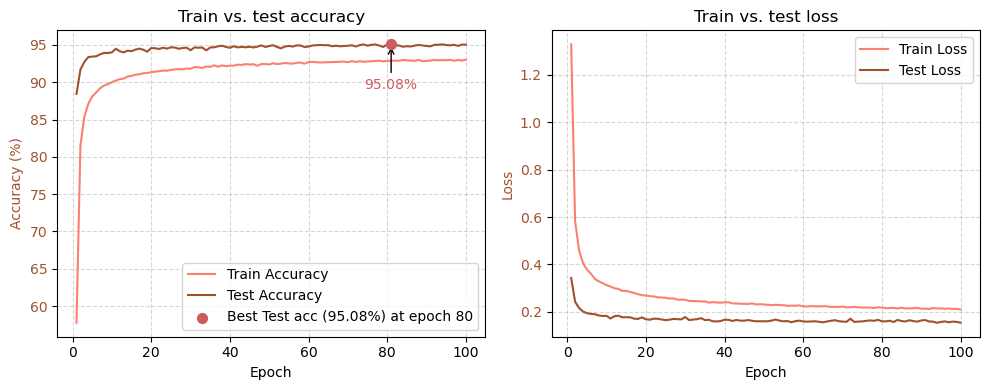

In [11]:
plot_stats(
    train_accuracies, 
    test_accuracies, 
    train_losses, 
    test_losses
)

### **Save results in file...**

In [12]:
filename = "CNN_results_constant_lr.txt"

with open(filename, "w") as f:
    f.write("Epoch, Train loss, Train acc, Test loss, Test acc\n")
    
    for i in range(num_epochs):
        f.write(
            f"{i+1}, "
            f"{train_losses[i]:.4f}, "
            f"{train_accuracies[i]:.2f}%, " 
            f"{test_losses[i]:.4f}, "
            f"{test_accuracies[i]:.2f}%\n")

    f.write("\n" + "="*40 + "\n")
    f.write("Final Metrics\n")
    f.write(f"Final Train Loss:     {train_losses[-1]:.4f}\n")
    f.write(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%\n")
    f.write(f"Final Test Loss:      {test_losses[-1]:.4f}\n")
    f.write(f"Final Test Accuracy:  {test_accuracies[-1]:.2f}%\n")
    f.write("="*40 + "\n")

print(f"Resultater gemt i: {filename}")

Resultater gemt i: CNN_results_constant_lr.txt


### **Gem efter træning:**

In [13]:
torch.save(model.state_dict(), "my_model_state_dict_constant_lr.pth")